# 1. モジュールインポート

In [2]:
import pandas as pd
import glob
import os
import datetime
from tqdm.auto import tqdm
from src.constants._master import Master
from src.constants._local_paths import LocalPaths
from src.constants._horse_results_cols import HorseResultsCols
from src.constants._results_cols import ResultsCols
from src import preparing


from src import training
from src import simulation
from src import policies
%load_ext autoreload

標準的な土日競馬開催時の運用スケジュールを以下の表の通り。

|曜日|時刻|内容|実行する main.ipynb の項番|備考|
|:-:|:--|:--|:--|:--|
|月|||||
|火|||||
|水|16:30過ぎ|先週土日の馬の過去成績ページ確定<BR>（netkeiba.comﾌﾟﾚﾐｱｻｰﾋﾞｽのﾀｲﾑ指数・ﾚｰｽ分析・注目馬 ﾚｰｽ後の短評情報確定）|2. データ取得 ～ 5. シミュレーション|3日間開催の場合も、水曜日|
|木|||||
|金|10:05過ぎ<BR>19:25過ぎ|土曜の出馬表確定<BR>土曜の天候・馬場状態更新|6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|土|09:00～17:00<BR>10:05過ぎ<BR>19:25過ぎ| レース時刻<BR>日曜の出馬表確定<BR>日曜の天候・馬場状態更新|6.3. レース直前データ処理（当日レース予想）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想（天候・馬場状態は手動設定）<BR>6.1. 前日準備 ～ 6.2. 前日全レース予想||
|日|09:00～17:00|レース時刻|6.3. レース直前データ処理（当日レース予想）||

# 2. データ取得

## 2.1. レースID取得
例として、2020年のレースデータを取得する場合を考える

In [162]:
%autoreload

In [163]:
#開催日取得。to_の月は含まないので注意。
kaisai_date_2020 = preparing.scrape_kaisai_date(from_="2020-01-01", to_="2021-01-01")
len(kaisai_date_2020)

AttributeError: module 'src.preparing' has no attribute 'scrape_kaisai_date'

In [ ]:
# 開催日からレースIDの取得
race_id_list = preparing.scrape_race_id_list(kaisai_date_2020)
len(race_id_list)

getting race_id_list


  0%|          | 0/109 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200105
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200106
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200111
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200112
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200113
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200118
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200119
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200125
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200126
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200201
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200202
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200208
scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20200209
scraping: ht

3456

## 2.2. /race/ディレクトリのデータ取得

In [ ]:
#https://db.netkeiba.com/race/のhtml(binファイル)をスクレイピングして保存
html_files_race = preparing.scrape_html_race(race_id_list, skip=True)
html_files_race[:5]

  0%|          | 0/10 [00:00<?, ?it/s]

race_id 202106010101 skipped
race_id 202106010102 skipped
race_id 202106010103 skipped
race_id 202106010104 skipped
race_id 202106010105 skipped
race_id 202106010106 skipped
race_id 202106010107 skipped
race_id 202106010108 skipped
race_id 202106010109 skipped
race_id 202106010110 skipped


['/Users/chiyoda/Documents/readers-repo/data/html/race/202106010101.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010102.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010103.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010104.bin',
 '/Users/chiyoda/Documents/readers-repo/data/html/race/202106010105.bin']

In [ ]:
results_new = preparing.get_rawdata_results(html_files_race) #レース結果テーブルの作成
race_info_new = preparing.get_rawdata_info(html_files_race) #レース情報テーブルの作成
return_tables_new = preparing.get_rawdata_return(html_files_race) #払戻テーブルの作成

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# テーブルの更新。元々のテーブルが存在しない場合は、新たに作成される。
preparing.update_rawdata(filepath=LocalPaths.RAW_RESULTS_PATH, new_df=results_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RACE_INFO_PATH, new_df=race_info_new)
preparing.update_rawdata(filepath=LocalPaths.RAW_RETURN_TABLES_PATH, new_df=return_tables_new)

## 2.3. /horse/ディレクトリのデータ取得

In [ ]:
%autoreload

In [ ]:
horse_id_list = results_new['horse_id'].unique()
#htmlをスクレイピング
#すでにスクレイピングしてある馬をスキップしたい場合はskip=Trueにする
#すでにスクレイピングしてある馬でも、新たに出走した成績を更新したい場合はskip=Falseにする
html_files_horse = preparing.scrape_html_horse_with_master(
    horse_id_list, skip=True
    )

scraping


  0%|          | 0/11398 [00:00<?, ?it/s]

horse_id 2015104603 skipped
horse_id 2015105549 skipped
horse_id 2015102342 skipped
horse_id 2015100933 skipped
horse_id 2015101022 skipped
horse_id 2015102419 skipped
horse_id 2015105621 skipped
horse_id 2015105800 skipped
horse_id 2015104474 skipped
horse_id 2015103929 skipped
horse_id 2015100339 skipped
horse_id 2015104336 skipped
horse_id 2015102908 skipped
horse_id 2015106192 skipped
horse_id 2015109150 skipped
horse_id 2015104834 skipped
horse_id 2015103859 skipped
horse_id 2014102886 skipped
horse_id 2014104214 skipped
horse_id 2013105161 skipped
horse_id 2013103739 skipped
horse_id 2014104550 skipped
horse_id 2014100779 skipped
horse_id 2014105398 skipped
horse_id 2014103417 skipped
horse_id 2015104752 skipped
horse_id 2015101028 skipped
horse_id 2015104408 skipped
horse_id 2015104271 skipped
horse_id 2015106094 skipped
horse_id 2015100244 skipped
horse_id 2015103112 skipped
horse_id 2015102242 skipped
horse_id 2015105018 skipped
horse_id 2015100299 skipped
horse_id 2015102983 

In [ ]:
#追加で新たにスクレイピングされた数
len(html_files_horse)

4742

In [ ]:
### scrape関数を実行せずに、保存してあるhtmlのパスを取得する場合、以下を実行 ###

"""target_date = '2022-06-25' #スクレイピングした日付を指定
# マスタの読み込み
update_master = pd.read_csv(
    LocalPaths.MASTER_RAW_HORSE_RESULTS_PATH,
    dtype=object
    )
# target_dateにスクレイピングしたhorse_idに絞り込む
filter = pd.to_datetime(update_master['updated_at']).dt.strftime('%Y-%m-%d') == target_date
horse_id_list = update_master[filter]['horse_id']

# binファイルのパスを取得
html_files_horse = []
for horse_id in tqdm(horse_id_list):
    file = glob.glob(os.path.join(LocalPaths.HTML_HORSE_DIR, horse_id+'*.bin'))[0]
    html_files_horse.append(file)
html_files_horse[:5]"""

  0%|          | 0/11561 [00:00<?, ?it/s]

['/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017101445.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2017109028.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016100106.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2015104412.bin',
 '/Users/chiyoda/repositories/keibaAI-v2/data/html/horse/2016105305.bin']

In [ ]:
# 馬の基本情報テーブルの作成
horse_info_new = preparing.get_rawdata_horse_info(html_files_horse)

In [ ]:
# 馬の基本情報テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_new)

In [ ]:
#　馬の過去成績テーブルの作成
horse_results_new = preparing.get_rawdata_horse_results(html_files_horse)

preparing raw horse_results table


  0%|          | 0/4742 [00:00<?, ?it/s]

In [ ]:
# テーブルの更新
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_new)

## 2.4. /ped/ディレクトリのデータ取得

In [ ]:
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True) #htmlをスクレイピング

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
peds_new = preparing.get_rawdata_peds(html_files_peds) #血統テーブルの作成
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_new) #テーブルの更新

  0%|          | 0/5 [00:00<?, ?it/s]

# 3. データ加工

In [25]:
#モジュールを更新した際、notebookに反映させるために使用。
#すでにインポートしてあるモジュールの更新が反映される。

%autoreload


In [26]:
from src.constants._master import Master
from src.constants._local_paths import LocalPaths
from src.constants._horse_results_cols import HorseResultsCols
from src.constants._results_cols import ResultsCols
import sys
from src.preprocessing._horse_results_processor import HorseResultsProcessor
from src.preprocessing._horse_info_processor import HorseInfoProcessor
from src.preprocessing._data_merger import DataMerger
from src.preprocessing._feature_engineering import FeatureEngineering
from src.preprocessing._peds_processor import PedsProcessor
from src.preprocessing._race_info_processor import RaceInfoProcessor
from src.preprocessing._results_processor import ResultsProcessor
from src.preprocessing._return_processor import ReturnProcessor
# from src.preprocessing._shutuba_table_processor import ShutubaTableProcessor
# from src.preprocessing._shutuba_data_merger import ShutubaDataMerger

# 前処理
results_processor = ResultsProcessor(filepath=LocalPaths.RAW_RESULTS_PATH)
race_info_processor = RaceInfoProcessor(filepath=LocalPaths.RAW_RACE_INFO_PATH)
return_processor = ReturnProcessor(filepath=LocalPaths.RAW_RETURN_TABLES_PATH)
horse_info_processor = HorseInfoProcessor(filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = HorseResultsProcessor(filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

馬の過去成績を集計しつつ、前処理の済みの全てのテーブルをマージする処理

In [27]:
import pandas as pd

# 表示を省略しないように設定
sys.maxsize = sys.maxsize
# 現在の最大表示数
print(pd.get_option("display.max_rows"))
print(pd.get_option("display.max_columns"))

# 新しく設定する最大表示数
pd.set_option("display.max_rows", 250)
pd.set_option("display.max_columns", 250)

60
20


In [28]:
# ターゲットエンコーディング時に「馬の成績」として扱う項目
TARGET_COLS = [
        HorseResultsCols.RANK,
        HorseResultsCols.PRIZE,
        HorseResultsCols.RANK_DIFF,
        'first_corner',
        'final_corner',
        'first_to_rank',
        'first_to_final',
        'final_to_rank',
        'time_seconds'
        ]
# horse_id列と共に、ターゲットエンコーディングの対象にする列
GROUP_COLS = [
        'course_len',
        'race_type',
        HorseResultsCols.PLACE
        ]

data_merger = DataMerger(
        results_processor,
        race_info_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
)
# 処理実行
data_merger.merge()

self._results race_id         int64
枠番              int64
馬番              int64
斤量            float64
単勝            float64
horse_id        int64
jockey_id       int64
trainer_id      int64
owner_id        int64
性              object
年齢              int64
体重              int64
体重変化            int64
n_horses        int64
rank            int64
dtype: object
self._race_info race_id                    int64
place                     object
days                       int64
times                      int64
date              datetime64[ns]
time                      object
race_type                 object
around                    object
course_len               float64
weather                   object
ground_state1             object
ground_state2             object
race_class                object
race_condition           float64
teiryo                     int64
barei                      int64
bettei                     int64
kokusai                    int64
shitei                     int64

  0%|          | 0/116 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/116 [00:00<?, ?it/s]

merge_horse                                               34977                39096  \
race_id                                202308020909         202309020607   
枠番                                                2                    1   
馬番                                                2                    1   
斤量                                             58.0                 58.0   
単勝                                            222.4                320.5   
horse_id                                 2011106610           2011106610   
jockey_id                                     01208                01034   
trainer_id                                    01077                01077   
owner_id                                     851009               851009   
性                                                 セ                    セ   
年齢                                               12                   12   
体重                                              478                  484   


In [29]:
data_merger

In [32]:
from src.preprocessing._feature_engineering import FeatureEngineering


# カテゴリ変数の処理
feature_engineering = (
    FeatureEngineering(data_merger)
    .add_interval()
    .add_agedays()
    .dumminize_sex()
    .dumminize_weather()
    .dumminize_around()
    .dumminize_race_class()
    .dumminize_ground_state1()
    .dumminize_ground_state2()
    .dumminize_race_type()
    .dumminize_kaisai()
    .encode_breeder_id()
    .encode_owner_id()
    .encode_trainer_id()
    .encode_jockey_id()
    .encode_horse_id()
)
#print(f"self.__data.columns:{feature_engineering.featured_data.columns}")


In [33]:
feature_engineering.featured_data.drop("time", axis=1, inplace=True)
feature_engineering.featured_data.drop("race_condition", axis=1, inplace=True)

In [34]:
import pickle
# pickle形式でデータを保存
with open("./data/tmp/featured_data_20240224.pickle", "wb") as f:
    pickle.dump(feature_engineering.featured_data, f)

In [35]:
results = pd.read_pickle("./data/tmp/featured_data_20240224.pickle")
results.sort_values(by="race_id").head()

,race_id,枠番,馬番,斤量,単勝,horse_id,jockey_id,trainer_id,owner_id,年齢,体重,体重変化,n_horses,rank,days,times,date,course_len,teiryo,barei,bettei,kokusai,shitei,tokushi,toku,handi,minarai,wakate,shogai,chiho,gai,kongo,hinba,kachi,kyushu,開催,着順_5R,賞金_5R,着差_5R,first_corner_5R,final_corner_5R,first_to_rank_5R,first_to_final_5R,final_to_rank_5R,time_seconds_5R,着順_course_len_5R,賞金_course_len_5R,着差_course_len_5R,first_corner_course_len_5R,final_corner_course_len_5R,first_to_rank_course_len_5R,first_to_final_course_len_5R,final_to_rank_course_len_5R,time_seconds_course_len_5R,着順_race_type_5R,賞金_race_type_5R,着差_race_type_5R,first_corner_race_type_5R,final_corner_race_type_5R,first_to_rank_race_type_5R,first_to_final_race_type_5R,final_to_rank_race_type_5R,time_seconds_race_type_5R,着順_開催_5R,賞金_開催_5R,着差_開催_5R,first_corner_開催_5R,final_corner_開催_5R,first_to_rank_開催_5R,first_to_final_開催_5R,final_to_rank_開催_5R,time_seconds_開催_5R,着順_9R,賞金_9R,着差_9R,first_corner_9R,final_corner_9R,first_to_rank_9R,first_to_final_9R,final_to_rank_9R,time_seconds_9R,着順_course_len_9R,賞金_course_len_9R,着差_course_len_9R,first_corner_course_len_9R,final_corner_course_len_9R,first_to_rank_course_len_9R,first_to_final_course_len_9R,final_to_rank_course_len_9R,time_seconds_course_len_9R,着順_race_type_9R,賞金_race_type_9R,着差_race_type_9R,first_corner_race_type_9R,final_corner_race_type_9R,first_to_rank_race_type_9R,first_to_final_race_type_9R,final_to_rank_race_type_9R,time_seconds_race_type_9R,着順_開催_9R,賞金_開催_9R,着差_開催_9R,first_corner_開催_9R,final_corner_開催_9R,first_to_rank_開催_9R,first_to_final_開催_9R,final_to_rank_開催_9R,time_seconds_開催_9R,着順_allR,賞金_allR,着差_allR,first_corner_allR,final_corner_allR,first_to_rank_allR,first_to_final_allR,final_to_rank_allR,time_seconds_allR,着順_course_len_allR,賞金_course_len_allR,着差_course_len_allR,first_corner_course_len_allR,final_corner_course_len_allR,first_to_rank_course_len_allR,first_to_final_course_len_allR,final_to_rank_course_len_allR,...,peds_30,peds_31,peds_32,peds_33,peds_34,peds_35,peds_36,peds_37,peds_38,peds_39,peds_40,peds_41,peds_42,peds_43,peds_44,peds_45,peds_46,peds_47,peds_48,peds_49,peds_50,peds_51,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61,interval,age_days,性__牡,性__牝,性__セ,weather__晴,weather__曇,weather__小雨,weather__雨,weather__小雪,weather__雪,around__右,around__左,around__直線,race_class__新馬,race_class__未勝利,race_class__1勝クラス,race_class__2勝クラス,race_class__3勝クラス,race_class__リステッド,race_class__オープン,race_class__オープン特別,race_class__G3,race_class__G2,race_class__G1,ground_state1__良,ground_state1__稍重,ground_state1__重,ground_state1__不良,ground_state2__良,ground_state2__稍重,ground_state2__重,ground_state2__不良,race_type__芝,race_type__ダート,race_type__障害,開催__01,開催__02,開催__03,開催__04,開催__05,開催__06,開催__07,開催__08,開催__09,開催__10,開催__30,開催__34,開催__35,開催__36,開催__42,開催__43,開催__44,開催__45,開催__46,開催__47,開催__48,開催__50,開催__51,開催__53,開催__54,開催__55,開催__56,開催__58,開催__60,開催__61,開催__62,開催__63,開催__64,開催__65,開催__66,開催__67,開催__68,開催__69,開催__70,開催__71,開催__72,開催__73,開催__74,開催__75,開催__76,開催__77,開催__78,開催__79,開催__80,開催__81,開催__82,開催__83,開催__84,開催__85,開催__86,開催__87,開催__88
0,202301010101,5,5,55.0,1.2,8367,33,8,846,2,452,-4,1,1,1,1,2023-07-22,12.0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,01,2.0,290.0,0.2,1.0,1.0,-1.0,0.0,-1.0,69.50,2.0,290.0,0.2,1.0,1.0,-1.0,0.0,-1.0,69.50,2.0,290.0,0.2,1.0,1.0,-1.0,0.0,-1.0,69.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,290.0,0.2,1.0,1.0,-1.0,0.0,-1.0,69.50,2.0,290.0,0.2,1.0,1.0,-1.0,0.0,-1.0,69.50,2.0,290.0,0.2,1.0,1.0,-1.0,0.0,-1.0,69.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,290.0,0.2,1.0,1.0,-1.0,0.0,-1.0,69.50,2.0,290.0,0.2,1.0,1.0,-1.0,0.0,-1.0,...,250,6069,784,24,57,32,22,116,180,134,29,279,122,279,200,109,165,1071,792,165,58,131,339,104,169,2205,1251,70,9,2649,137,116,14.0,878,True,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,Fals

# 4. 学習

In [36]:
from src.training._keiba_ai_factory import KeibaAIFactory
from src.preprocessing._feature_engineering import FeatureEngineering

keiba_ai = KeibaAIFactory.create(feature_engineering.featured_data)  # モデル作成
keiba_ai.train_with_tuning()  # パラメータチューニングをして学習

[I 2024-02-25 14:33:28,655] A new study created in memory with name: no-name-ff139cfc-ee56-4e47-9126-506445e69a90
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction, val_score: 0.551601:  14%|#4        | 1/7 [00:06<00:38,  6.45s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction, val_score: 0.551601:  29%|##8       | 2/7 [00:13<00:33,  6.69s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction, val_score: 0.551601:  43%|####2     | 3/7 [00:26<00:38,  9.58s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction, val_score: 0.551601:  57%|#####7    | 4/7 [00:35<00:27,  9.32s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction, val_score: 0.551601:  71%|#######1  | 5/7 [00:43<00:17,  8.91s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction, val_score: 0.551601:  86%|########5 | 6/7 [00:54<00:09,  9.70s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.551601:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.551601:   5%|5         | 1/20 [00:20<06:22, 20.14s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.551601:  10%|#         | 2/20 [00:31<04:33, 15.22s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.551601:  15%|#5        | 3/20 [00:48<04:27, 15.71s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

num_leaves, val_score: 0.551601:  20%|##        | 4/20 [01:16<05:31, 20.73s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

num_leaves, val_score: 0.551601:  25%|##5       | 5/20 [01:46<06:02, 24.15s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.483705:  30%|###       | 6/20 [01:49<03:54, 16.77s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.483705:  35%|###5      | 7/20 [01:59<03:08, 14.53s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.483705:  40%|####      | 8/20 [02:02<02:12, 11.00s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.483705:  45%|####5     | 9/20 [02:06<01:35,  8.67s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.483705:  50%|#####     | 10/20 [02:14<01:25,  8.53s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.483705:  55%|#####5    | 11/20 [02:32<01:41, 11.31s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.483705:  60%|######    | 12/20 [02:56<02:02, 15.37s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.481168:  65%|######5   | 13/20 [02:59<01:21, 11.59s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.481168:  70%|#######   | 14/20 [03:08<01:05, 10.93s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.481168:  75%|#######5  | 15/20 [03:12<00:43,  8.61s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.481168:  80%|########  | 16/20 [03:19<00:32,  8.20s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.481168:  85%|########5 | 17/20 [03:41<00:36, 12.22s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.481168:  90%|######### | 18/20 [03:45<00:19,  9.89s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


num_leaves, val_score: 0.481168:  95%|#########5| 19/20 [03:52<00:08,  8.95s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481168:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481168:  10%|#         | 1/10 [00:02<00:22,  2.52s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481168:  20%|##        | 2/10 [00:06<00:27,  3.43s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481168:  30%|###       | 3/10 [00:10<00:26,  3.81s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481168:  40%|####      | 4/10 [00:14<00:21,  3.58s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481017:  50%|#####     | 5/10 [00:17<00:16,  3.35s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481017:  60%|######    | 6/10 [00:19<00:12,  3.17s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481017:  70%|#######   | 7/10 [00:22<00:09,  3.00s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481017:  80%|########  | 8/10 [00:25<00:05,  2.94s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


bagging, val_score: 0.481017:  90%|######### | 9/10 [00:27<00:02,  2.83s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction_stage2, val_score: 0.481017:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction_stage2, val_score: 0.481017:  17%|#6        | 1/6 [00:03<00:16,  3.24s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction_stage2, val_score: 0.481017:  33%|###3      | 2/6 [00:06<00:12,  3.12s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction_stage2, val_score: 0.481017:  50%|#####     | 3/6 [00:09<00:09,  3.00s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction_stage2, val_score: 0.481017:  67%|######6   | 4/6 [00:12<00:05,  2.96s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


feature_fraction_stage2, val_score: 0.481017:  83%|########3 | 5/6 [00:14<00:02,  2.91s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:   5%|5         | 1/20 [00:04<01:17,  4.07s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  10%|#         | 2/20 [00:07<01:06,  3.68s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  15%|#5        | 3/20 [00:10<00:59,  3.49s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  20%|##        | 4/20 [00:13<00:52,  3.29s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  25%|##5       | 5/20 [00:16<00:47,  3.16s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  30%|###       | 6/20 [00:20<00:47,  3.37s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  35%|###5      | 7/20 [00:23<00:43,  3.38s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  40%|####      | 8/20 [00:26<00:38,  3.25s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  45%|####5     | 9/20 [00:29<00:34,  3.16s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  50%|#####     | 10/20 [00:33<00:34,  3.41s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  55%|#####5    | 11/20 [00:36<00:29,  3.26s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481017:  60%|######    | 12/20 [00:39<00:25,  3.21s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481016:  65%|######5   | 13/20 [00:42<00:21,  3.11s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481016:  70%|#######   | 14/20 [00:46<00:19,  3.20s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481016:  75%|#######5  | 15/20 [00:49<00:15,  3.17s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481016:  80%|########  | 16/20 [00:52<00:12,  3.09s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481016:  85%|########5 | 17/20 [00:57<00:11,  3.86s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481016:  90%|######### | 18/20 [01:00<00:07,  3.58s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


regularization_factors, val_score: 0.481016:  95%|#########5| 19/20 [01:03<00:03,  3.40s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


min_child_samples, val_score: 0.481016:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


min_child_samples, val_score: 0.481016:  20%|##        | 1/5 [00:04<00:17,  4.25s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


min_child_samples, val_score: 0.481016:  40%|####      | 2/5 [00:08<00:13,  4.35s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


min_child_samples, val_score: 0.481016:  60%|######    | 3/5 [00:11<00:07,  3.73s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


min_child_samples, val_score: 0.481016:  80%|########  | 4/5 [00:14<00:03,  3.41s/it]

[LightGBM] [Info] Number of positive: 5450, number of negative: 19701
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36677
[LightGBM] [Info] Number of data points in the train set: 25151, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216691 -> initscore=-1.285054
[LightGBM] [Info] Start training from score -1.285054


min_child_samples, val_score: 0.481016: 100%|##########| 5/5 [00:18<00:00,  3.74s/it]


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.00024857882123589825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024857882123589825
[LightGBM] [Warning] lambda_l1 is set=0.00014685634665064263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014685634665064263
[LightGBM] [Warning] bagging_fraction is set=0.9912074372935157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9912074372935157
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.00024857882123589825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024857882123589825
[LightGBM] [Warning] lambda_l1 is set=0.00014685634665064263, reg_alpha=

In [37]:
from src.training._keiba_ai import KeibaAI

# 特徴量の重要度
keiba_ai.feature_importance(20)

,features,importance
219,race_class__未勝利,14
204,interval,11
205,age_days,11
9,体重,10
3,斤量,9
33,着順_5R,8
8,年齢,8
34,賞金_5R,7
69,着順_9R,7
123,着順_race_type_allR,6


In [38]:
#ハイパーパラメータの確認
keiba_ai.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 3,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_pre_filter': False,
 'lambda_l1': 0.00014685634665064263,
 'lambda_l2': 0.00024857882123589825,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.9912074372935157,
 'bagging_freq': 7}

In [341]:
#チューニングしないで学習
keiba_ai.train_without_tuning()

[LightGBM] [Warning] feature_fraction is set=0.516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516
[LightGBM] [Warning] lambda_l2 is set=8.219195802626776e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.219195802626776e-05
[LightGBM] [Warning] lambda_l1 is set=7.344916963317897e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.344916963317897e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516
[LightGBM] [Warning] lambda_l2 is set=8.219195802626776e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.219195802626776e-05
[LightGBM] [Warning] lambda_l1 is set=7.344916963317897e-05, reg_alpha=0.0 will be ignored. Current 

In [39]:
from src.training._keiba_ai_factory import KeibaAIFactory

# モデル保存。models/(実行した日付)/(version_name).pickleに、モデルとデータセットが保存される。
KeibaAIFactory.save(keiba_ai, version_name="basemodel_2023_2024")

In [40]:
# モデルロード
keiba_ai = KeibaAIFactory.load("models/20240224/basemodel_2023_2024.pickle")
keiba_ai.set_params(keiba_ai.get_params())

# 5. シミュレーション

In [166]:
%autoreload

In [167]:
from src.simulation._simulator import Simulator

# シミュレーターに馬券をセット
simulator = Simulator(return_processor)
print(f"simulator :{simulator}")

simulator :<src.simulation._simulator.Simulator object at 0x7fd06a37b190>


In [168]:
# from src.policies._score_policy import StdScorePolicy
from src.policies._score_policy import BasicScorePolicy

feature_engineering.featured_data.head()
# スコアテーブルを取得
score_table = keiba_ai.calc_score(keiba_ai.datasets.X_test, BasicScorePolicy)
print(f"score:{score_table}")
# 18列目のすべての値とその個数を取得
# column_2_counts = score_table.iloc[:, 2].value_counts()
# 結果の表示
# print(column_2_counts)

score_tabel_copy:               馬番     単勝
race_id                
202308020108   4    6.5
202308020109  14   22.2
202308020110  16   84.2
202308020111   2    7.9
202308020101   9  120.7
...           ..    ...
202408020201   9   60.2
202408020202  12  524.2
202408020203   9   66.0
202408020205  14    1.5
202410010612   8   85.5

[1114 rows x 2 columns]
[LightGBM] [Warning] feature_fraction is set=0.516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516
[LightGBM] [Warning] lambda_l2 is set=8.219195802626776e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.219195802626776e-05
[LightGBM] [Warning] lambda_l1 is set=7.344916963317897e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.344916963317897e-05
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
score:       

## 5.1. 単一threshold

### 5.1.1 単勝馬券

In [169]:
from src.policies._bet_policy import BetPolicyTansho

T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
            score_table,  # スコアテーブル
            BetPolicyTansho,  # 賭け方の方針
            threshold=threshold,  # 「馬の勝ちやすさスコア」の閾値
        )
        # print("actions:",actions.dtypes)

        returns[threshold] = simulator.calc_returns(actions)
        print(f"returns:{returns}")

    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient="index")

returns_df.index.name = "threshold"
print(f"returns_df:{returns_df.head()}")

  0%|          | 0/100 [00:00<?, ?it/s]

bet_dict:{202303030202: {'tansho': [11]}, 202303030308: {'tansho': [9]}, 202303030408: {'tansho': [1]}, 202303030507: {'tansho': [2]}, 202303030512: {'tansho': [13]}, 202304040404: {'tansho': [4]}, 202304040405: {'tansho': [7]}, 202304040412: {'tansho': [10]}, 202305040301: {'tansho': [11]}, 202305040302: {'tansho': [2]}, 202305040303: {'tansho': [9]}, 202305040709: {'tansho': [8]}, 202305040710: {'tansho': [11]}, 202305040711: {'tansho': [9]}, 202305040808: {'tansho': [14]}, 202305050304: {'tansho': [14]}, 202305050306: {'tansho': [11]}, 202305050801: {'tansho': [1]}, 202306050101: {'tansho': [1]}, 202306050110: {'tansho': [3]}, 202306050703: {'tansho': [12]}, 202306050911: {'tansho': [13]}, 202307040301: {'tansho': [1]}, 202307040608: {'tansho': [10]}, 202308020302: {'tansho': [15]}, 202308020407: {'tansho': [8]}, 202308020411: {'tansho': [9]}, 202308020912: {'tansho': [9]}, 202308030102: {'tansho': [10]}, 202308030203: {'tansho': [12]}, 202308030302: {'tansho': [10]}, 202308030606: 

In [386]:
#シミュレーション結果も、models/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20240224/tansho.pickle')

In [387]:
from src.simulation._plot import plot_single_threshold

# 回収率をプロット
plot_single_threshold(returns_df, N_SAMPLES, label="tansho")

df:Empty DataFrame
Columns: []
Index: []


KeyError: 'return_rate'

<Figure size 640x480 with 0 Axes>

### 5.1.2 複勝馬券

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyFukusho, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/fukusho.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='fukusho')

### 5.1.3 馬連BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmarenBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/umarenbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umarenbox')

### 5.1.4 馬単BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyUmatanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/umatanbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='umatanbox')

### 5.1.5 ワイドBOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicyWideBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/widebox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='widebox')

### 5.1.6 三連複BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrenpukuBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/sanrenpukubox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrenpukubox')

### 5.1.7 三連単BOX

In [ ]:
T_RANGE = [0.5, 3.5]
N_SAMPLES = 100
returns = {}

# 「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
for i in tqdm(range(N_SAMPLES)):
    # T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold = T_RANGE[1] * i / N_SAMPLES + T_RANGE[0] * (1 - (i / N_SAMPLES))
    try:
        # 賭ける馬券を決定
        actions = keiba_ai.decide_action(
                score_table, # スコアテーブル
                policies.BetPolicySanrentanBox, # 賭け方の方針
                threshold=threshold # 「馬の勝ちやすさスコア」の閾値
                )
        returns[threshold] = simulator.calc_returns(actions)
    except Exception as e:
        print(e)
        break
returns_df = pd.DataFrame.from_dict(returns, orient='index')
returns_df.index.name = 'threshold'

In [ ]:
# シミュレーション結果も、models/YYYYMMDD/に保存しておくとわかりやすい。
returns_df.to_pickle('models/20220626/sanrentanbox.pickle')

In [ ]:
# 回収率をプロット
simulation.plot_single_threshold(returns_df, N_SAMPLES, label='sanrentanbox')

## 5.2. 複数馬券
未実装

## 5.3. 複数threshold
未実装だが、以下のようなコードになる予定。

In [ ]:
T1_RANGE = [2.5, 3.5]
MIN_T2 = 1
N_SAMPLES = 10

returns = {}
#「馬の勝ちやすさスコア」の閾値を変化させた時の成績を計算
idx = 0
for i in tqdm(range(N_SAMPLES)):
    #T_RANGEの範囲を、N_SAMPLES等分して、thresholdをfor分で回す
    threshold1 = T1_RANGE[1] * i / N_SAMPLES + T1_RANGE[0] * (1-(i/N_SAMPLES))
    for j in range(N_SAMPLES):
        #MIN_T2からthreshold1までをN_SAMPLES等分
        threshold2 = threshold1 * j / N_SAMPLES + MIN_T2 * (1-(j/N_SAMPLES))
        try:
            #print(threshold1, threshold2)
            #賭ける馬券を決定
            actions = keiba_ai.decide_action(
                    score_table, # スコアテーブル
                    policies.BetPolicyTanshoFukusho, # 賭け方の方針(未実装)
                    threshold1=threshold1, #「馬の勝ちやすさスコア」の閾値
                    threshold2=threshold2
                    )
            returns[idx] = simulator.calc_returns(actions)
            idx += 1
        except Exception as e:
            print(e)
            break
returns_df = pd.DataFrame.from_dict(returns, orient='index')

  0%|          | 0/10 [00:00<?, ?it/s]

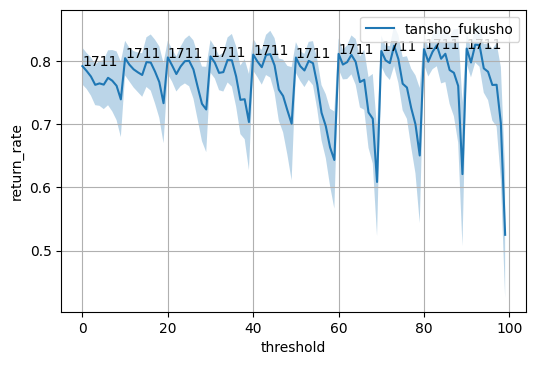

In [ ]:
simulation.plot_single_threshold(returns_df.reset_index(), 100, label='tansho_fukusho')

# 6. 当日の予想
例として2022年1月8日のレースを実際に予想する場合を考える。  
https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108

## 6.1. 前日準備

In [ ]:
%autoreload

In [ ]:
race_id_list = preparing.scrape_race_id_list(['20220108']) #レースidを取得
len(race_id_list)

getting race_id_list


  0%|          | 0/1 [00:00<?, ?it/s]

scraping: https://race.netkeiba.com/top/race_list.html?kaisai_date=20220108


24

In [ ]:
#出走するhorse_idの取得
horse_id_list = preparing.scrape_horse_id_list(race_id_list)
len(horse_id_list)

sraping horse_id_list


  0%|          | 0/24 [00:00<?, ?it/s]

361

In [ ]:
#horseページのhtmlをスクレイピング
#直近レースが更新されている可能性があるので、skip=Falseにして上書きする
html_files_horse = preparing.scrape_html_horse_with_master(horse_id_list, skip=False)

In [ ]:
#horse_infoテーブルの更新
horse_info_20220108 = preparing.get_rawdata_horse_info(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_INFO_PATH, horse_info_20220108)

In [ ]:
#horse_resultsテーブルの更新
horse_results_20220108 = preparing.get_rawdata_horse_results(html_files_horse)
preparing.update_rawdata(LocalPaths.RAW_HORSE_RESULTS_PATH, horse_results_20220108)

In [ ]:
#pedsテーブルの更新
html_files_peds = preparing.scrape_html_ped(horse_id_list, skip=True)
peds_20220108 = preparing.get_rawdata_peds(html_files_peds)
preparing.update_rawdata(LocalPaths.RAW_PEDS_PATH, peds_20220108)

In [ ]:
#processorの更新
horse_info_processor = preprocessing.HorseInfoProcessor(
    filepath=LocalPaths.RAW_HORSE_INFO_PATH)
horse_results_processor = preprocessing.HorseResultsProcessor(
    filepath=LocalPaths.RAW_HORSE_RESULTS_PATH)
peds_processor = preprocessing.PedsProcessor(filepath=LocalPaths.RAW_PEDS_PATH)

In [ ]:
#モデルの準備
keiba_ai = training.KeibaAIFactory.load('models/20220626/basemodel_2018_2021.pickle')

## 6.2. 前日全レース予想

In [ ]:
%autoreload

In [ ]:
# 前日全レース予想用のレースidとレース発走時刻を取得
target_race_id_list, target_race_time_list = preparing.scrape_race_id_race_time_list('20221001')
print(len(target_race_id_list))
print(len(target_race_time_list))
yesterday = True

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
today = '2022/10/01'

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 前日予想の場合
    if yesterday:
        # 前日予想の場合、馬体重を0（0）に補正
        pd2 = pd.read_pickle(filepath)
        pd2[ResultsCols.WEIGHT_AND_DIFF] = '0(0)'
        # 前日予想の場合、天候と馬場状態が公開されていない場合はこちらを有効にする
        #pd2['weather'] = '晴'
        #pd2['ground_state'] = '良'
        pd2.to_pickle(filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.3. レース直前データ処理（当日レース予想）

In [ ]:
%autoreload

In [ ]:
# 馬体重の発表されたレースID、レース時刻を取得（レース当日用）
target_race_id_list, target_race_time_list = preparing.create_active_race_id_list()
print((target_race_id_list))
print((target_race_time_list))

In [ ]:
# 一時的に出馬表を保存するパスを指定
filepath = 'data/tmp/shutuba.pickle'
#today = '2022/10/01'
today = datetime.datetime.now().date().strftime('%Y/%m/%d')

for race_id, race_time in zip(target_race_id_list, target_race_time_list):
    # 出馬表の取得
    preparing.scrape_shutuba_table(race_id, today, filepath)

    # 出馬表の加工
    shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath)

    # テーブルのマージ
    shutuba_data_merger = preprocessing.ShutubaDataMerger(
        shutuba_table_processor,
        horse_results_processor,
        horse_info_processor,
        peds_processor,
        target_cols=TARGET_COLS,
        group_cols=GROUP_COLS
    )
    shutuba_data_merger.merge()

    # 特徴量エンジニアリング
    feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger) \
        .add_interval()\
        .add_agedays()\
        .dumminize_ground_state()\
        .dumminize_race_type()\
        .dumminize_sex()\
        .dumminize_weather()\
        .encode_horse_id()\
        .encode_jockey_id()\
        .encode_trainer_id()\
        .encode_owner_id()\
        .encode_breeder_id()\
        .dumminize_kaisai()\
        .dumminize_around()\
        .dumminize_race_class()

    # 予測
    X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)

    # 当日の出走情報テーブル（前処理前）
    df_tmp = shutuba_table_processor.raw_data[:1]
    #df_tmp['race_type'] tmp.iat[0, 12]
    #df_tmp['around'] 13
    #df_tmp['weather'] 14
    #df_tmp['ground_state'] 15
    #df_tmp['race_class']16

    i = 0
    for num in list(Master.PLACE_DICT.values()):
        if num == race_id[4:6]:
            print(list(Master.PLACE_DICT)[i] + race_id[10:12] + 'R ' + race_time + '発走 ' + str(df_tmp.iat[0, 12])
                + str(df_tmp.iat[0, 10]) + 'm ' + str(df_tmp.iat[0, 13]) + ' ' + str(df_tmp.iat[0, 15]))
            break
        i += 1

    print(keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False))

## 6.4. レース直前データ処理（旧方式）

In [ ]:
filepath = 'data/tmp/shutuba.pickle' #一時的に出馬表を保存するパスを指定
preparing.scrape_shutuba_table(race_id_list[0], '2022/1/8', filepath) #馬体重が発表されたら、出馬表を取得
shutuba_table_processor = preprocessing.ShutubaTableProcessor(filepath) #出馬表の加工

In [ ]:
#テーブルのマージ
shutuba_data_merger = preprocessing.ShutubaDataMerger(
    shutuba_table_processor,
    horse_results_processor,
    horse_info_processor,
    peds_processor,
    target_cols=TARGET_COLS,
    group_cols=GROUP_COLS
)

shutuba_data_merger.merge()

separating horse results by date


  0%|          | 0/1 [00:00<?, ?it/s]

merging horse_results


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#特徴量エンジニアリング
feature_enginnering_shutuba = preprocessing.FeatureEngineering(shutuba_data_merger)\
    .add_interval()\
    .add_agedays()\
    .dumminize_ground_state()\
    .dumminize_race_type()\
    .dumminize_sex()\
    .dumminize_weather()\
    .encode_horse_id()\
    .encode_jockey_id()\
    .encode_trainer_id()\
    .encode_owner_id()\
    .encode_breeder_id()\
    .dumminize_kaisai()\
    .dumminize_around()\
    .dumminize_race_class()

In [ ]:
#予測
X = feature_enginnering_shutuba.featured_data.drop(['date'], axis=1)
keiba_ai.calc_score(X, policies.StdScorePolicy).sort_values('score', ascending=False)

,馬番,単勝,score
202206010201,5,4.7,1.972623
202206010201,3,4.3,1.698477
202206010201,15,4.5,1.292167
202206010201,4,5.7,0.754306
202206010201,11,5.4,0.706008
202206010201,6,16.9,0.401887
202206010201,16,14.2,-0.070303
202206010201,1,26.7,-0.260754
202206010201,13,29.8,-0.300251
202206010201,9,101.3,-0.481400
